#### 라이브러리 불러오기

In [24]:
import os
import platform
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import lightgbm as lgb

from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from model_evaluation import regression_evaluation, f_importances

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#### 설정

##### 공통

In [25]:
SEED = 1234

##### 차트 한글설정

In [26]:
import platform

_os_name = platform.system()

# font_path는 사용할 폰트에 따라 변경하면 됨
_font_path = 'c:/Windows/Fonts/malgun.ttf' if _os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
_font_family = fm.FontProperties(fname=_font_path).get_name()

# font 설정
plt.rcParams['font.family'] = _font_family

# 폰트캐시까지 삭제 후 한글폰트가 사용될 수 있도록 캐시 삭제
# --> 이렇게 해야 비로소 한글이 표현되는 경우가 많음
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [_font_family]

_fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, _fe)

#### 데이터 불러오기

In [27]:
PATH_BASE = os.path.join(os.getcwd(), 'data', '33-sun-power')
PATH_POWER = os.path.join(PATH_BASE, 'sun_energy.csv')
PATH_WEATHER = os.path.join(PATH_BASE, 'weather_2017_2022.csv')
PATH_TEST = os.path.join(PATH_BASE, 'sun_energy_test.csv')

In [28]:
df_sun_power = pd.read_csv(PATH_POWER)
df_weather = pd.read_csv(PATH_WEATHER)
df_test = pd.read_csv(PATH_TEST)

##### 데이터 확인

In [29]:
# 시계열 데이터를 이용하기 때문에 일자 데이터의 범위와 갯 수 확인
print(
    f'  power: {df_sun_power.날짜.min()} ~ {df_sun_power.날짜.max()}, cnt: {df_sun_power.shape[0]:>4}\n'
    f'weather: {df_weather.tm.min()} ~ {df_weather.tm.max()}, {df_weather.shape[0]:>9}\n'
    f'   test: {df_test.tm.min()} ~ {df_test.tm.max()}, {df_test.shape[0]:>9}'
)
# 시험데이터가 훈련데이터에 포함되 있음

  power: 2017-01-01 ~ 2022-12-31, cnt: 2191
weather: 2017-01-01 ~ 2022-12-31,      2191
   test: 2022-07-09 ~ 2022-12-31,       176


In [30]:
# 일자계산(누락데이터 여부 확인)
date_start = datetime.strptime(df_weather.tm.min(), '%Y-%m-%d')
date_end = datetime.strptime(df_weather.tm.max(), '%Y-%m-%d')
print(f'일자계산: {(date_end-date_start).days}')
# 누락데이터는 없음

일자계산: 2190


#### 데이터 전처리

##### 데이터 결합 및 컬럼 정리

* 훈련데이터 결합

In [31]:
# key로 사용할 날짜데이터 형식 변경: object -> datetime64
df_sun_power.날짜 = pd.to_datetime(df_sun_power.날짜)
df_weather.tm = pd.to_datetime(df_weather.tm)

# 당장 시계열처리를 할게 아니기 때문에, 날짜 데이터를 인덱스로 사용하지 않음

# 두 데이터프레임의 크기가 같기 때문에 아무 방향으로 결합해도 되기 때문에,
# 여기서는 기상데이터를 기반으로 결합함
df_train = pd.merge(df_weather, df_sun_power, left_on='tm', right_on='날짜', how='inner')

* 시험데이터 확인

In [32]:
df_test.tm = pd.to_datetime(df_test.tm)

* 훈련/시험데이터 컬럼 통일

In [33]:
# 컬럼 고유값이 1개인 컬럼 제거(훈련데이터 기준)
_train_n_unique = df_train.nunique()
print(_train_n_unique[_train_n_unique==1].index)

_drop_cols = df_train.columns[_train_n_unique==1]
df_train.drop(columns=_drop_cols, axis=1, inplace=True)
df_test.drop(columns=_drop_cols, axis=1, inplace=True, errors='ignore')

Index(['stnId', 'stnNm', 'iscs', '발전기명', '주소', '설비용량(MW)'], dtype='object')


In [34]:
# merge 시 중복된 날짜컬럼 삭제
_drop_cols = ['날짜', '날짜_tm', 'Unnamed: 0', ]
df_train.drop(columns=_drop_cols, axis=1, inplace=True, errors='ignore')
df_test.drop(columns=_drop_cols, axis=1, inplace=True, errors='ignore')

In [35]:
# 컬럼 통일
df_train = df_train[df_test.columns]

##### 결측치 처리

In [36]:
df_train.isna().sum().sort_values(ascending=False)

avgLmac           606
avgTca            581
sumSmlEv           17
sumLrgEv           17
avgCm5Te           15
avgCm30Te          12
avgCm20Te          12
avgCm10Te          12
avgPv              12
avgRhm             12
avgTd              12
maxWd              10
avgPs               9
avgPa               9
avgTa               9
sumSsHr             6
sumGsr              4
minRhm              4
minRhmHrmt          4
hr1MaxIcsrHrmt      3
minPs               3
hr1MaxIcsr          3
ssDur               2
maxTa               1
minTg               1
minTaHrmt           1
avgTs               1
maxInsWs            1
maxInsWsWd          1
minTa               1
maxTaHrmt           1
hr24SumRws          1
avgWs               1
maxInsWsHrmt        1
minPsHrmt           1
maxPsHrmt           1
maxPs               1
maxWs               1
maxWsWd             1
maxWsHrmt           1
tm                  0
일일발전량(Wh)           0
dtype: int64

In [37]:
# 첫 로우가 NaN인 경우 interpolate()함수가 결측치 처리를 못함
# 따라서 첫 로우의 값을 평균값으로 주고 싶은데, 
# 전체 평균값이 아닌 해당 월 평균값으로 주고 싶기 때문에 월 컬럼 추가
# (월 컬럼은 태양광발전량이 월에 영향을 많이 받기 때문에 평균값 계산이 아니여도 추가해야함)

df_train['month'] = df_train.tm.dt.month
# 컬럼추가는 훈련데이터에 했으면 시험데이터에도 해야함
df_test['month'] = df_test.tm.dt.month

In [38]:
# 월별 'avgLmac', 'avgTac' 컬럼의 평균 계산
_monthly_avg = df_train.groupby('month')[['avgLmac', 'avgTca']].mean()

# 첫번째 row의 월 추출
_first_month = df_train.loc[0, 'month']

# 첫번째 row의 월에 해당하는 두 컬럼의 평균값 추출
_first_avgLmac = _monthly_avg.loc[_first_month, 'avgLmac']
_first_avgTca = _monthly_avg.loc[_first_month, 'avgTca']

# 첫번째 row의 두 컬럼에 있는 NaN값을 평균값으로 대체
df_train.loc[0, ['avgLmac', 'avgTca']] = [_first_avgLmac, _first_avgTca]

In [39]:
# 인덱스가 시계열 컬럼일 경우, 시계열성을 반영해 중간값 지정
df_train = df_train.interpolate()

##### 일자별 발전량 차트

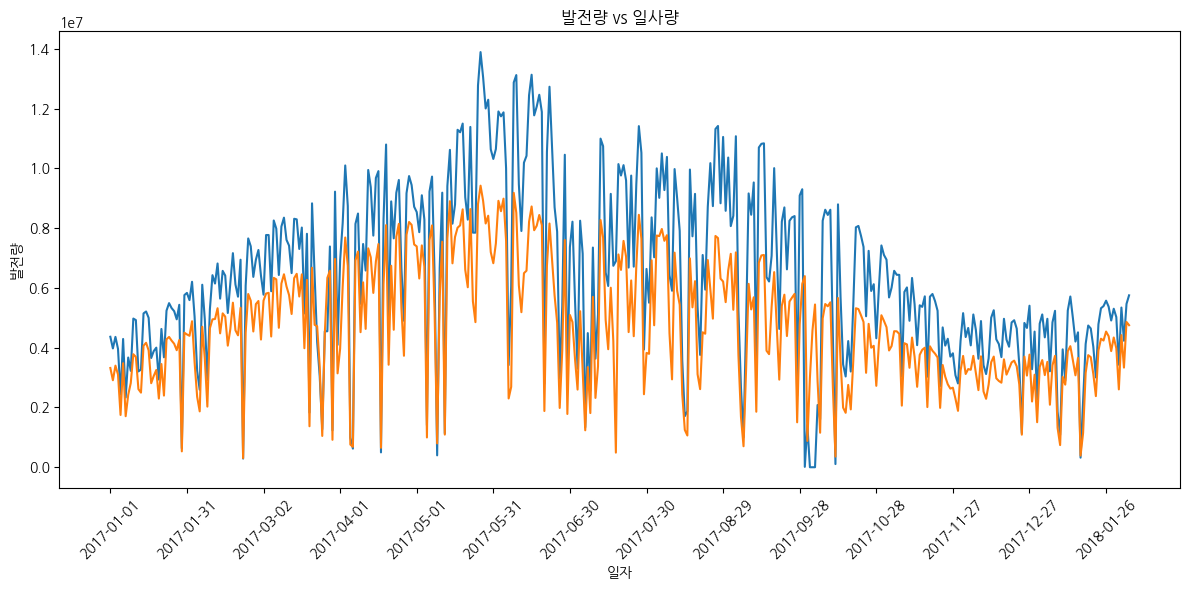

In [40]:
plt.figure(figsize=(12,6))
plt.plot(df_train['tm'][:400], df_train['일일발전량(Wh)'][:400])
plt.plot(df_train['tm'][:400], df_train['sumGsr'][:400]*300000)
plt.xlabel('일자')
plt.ylabel('발전량')
plt.xticks(df_train['tm'][:400:30], rotation=45)
plt.title('발전량 vs 일사량')
plt.tight_layout()
plt.show()

# 대략 1년(400일) 데이터
# 우리나라 태양광발전량의 일반적 패턴은:
#  - 5월10일~6월20일(장마전)까지 가장 높은 발전량을 보이며,
#  - 7~8월의 일사량은 5~6월 보다 좋지 않음(이때는 온도가 높아 패널에 저항이 많이 생김)

##### 속성과 목표컬럼 분리
* 이 부분은 `전처리 마지막`에 해도 되지만, 속성컬럼 부분의 `정규화 등의 후속 전처리`를 위해 여기서 수행함

In [41]:
target_col = '일일발전량(Wh)'

# 시계열처리를 하는것이 아니기 때문에 'tm'도 제거
_drop_cols = [target_col, 'tm']

X_train, y_train = df_train.drop(_drop_cols, axis=1), df_train[target_col]
X_test, y_test = df_test.drop(_drop_cols, axis=1), df_test[target_col]

#### ML 모델링

##### DecisionTreeRegressor I

In [42]:
# 특별한 처리없이 기본값으로 처리
model_dtr = DecisionTreeRegressor().fit(X_train, y_train)
pred_dtr = model_dtr.predict(X_test)
_ = regression_evaluation(y_test, pred_dtr)

# 훈련데이터에 시험데이터가 포함되어 있어 정확도가 100%임.


R2_SCORE: 1.000000, MAPE2: 0.000000, MSE: 0.000000, RMSE: 0.000000, MAPE: 0.000000, MAE: 0.000000


##### 훈련데이터에서 시험데이터 제거

In [43]:
date_cutoff = df_test.tm.min()

df_cutoff = df_train[df_train.tm < date_cutoff]

In [44]:
df_cutoff.to_csv(os.path.join(PATH_BASE, 'pp_train.csv'), index=False)
df_test.to_csv(os.path.join(PATH_BASE, 'pp_test.csv'), index=False)

In [45]:

# X_train, y_train 다시 생성
X_train, y_train = df_cutoff.drop(_drop_cols, axis=1), df_cutoff[target_col]

##### DecisionTreeRegressor II

In [46]:
model_dtr = DecisionTreeRegressor().fit(X_train, y_train)
pred_dtr = model_dtr.predict(X_test)
_ = regression_evaluation(y_test, pred_dtr)

R2_SCORE: 0.824900, MAPE2: 13.433945, MSE: 1319705809772.727295, RMSE: 1148784.492310, MAPE: 0.175054, MAE: 686914.772727


* 영향도

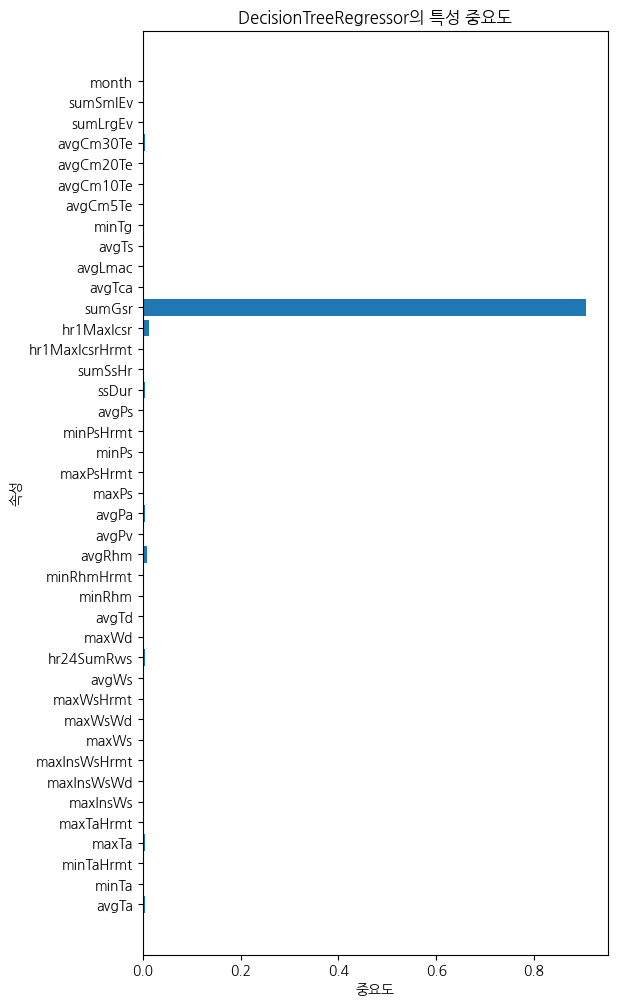

In [47]:
f_importances(model_dtr, X_train.columns, 'DecisionTreeRegressor의 특성 중요도')

##### RandomForestRegressor

In [48]:
model_rfr = RandomForestRegressor(
    n_estimators=500, n_jobs=-1, random_state=SEED
).fit(X_train, y_train)

pred_rfr = model_rfr.predict(X_test)
_ = regression_evaluation(y_test, pred_rfr)

R2_SCORE: 0.891862, MAPE2: 9.630587, MSE: 815021331591.681763, RMSE: 902785.318662, MAPE: 0.127476, MAE: 533456.427273


* 영향도

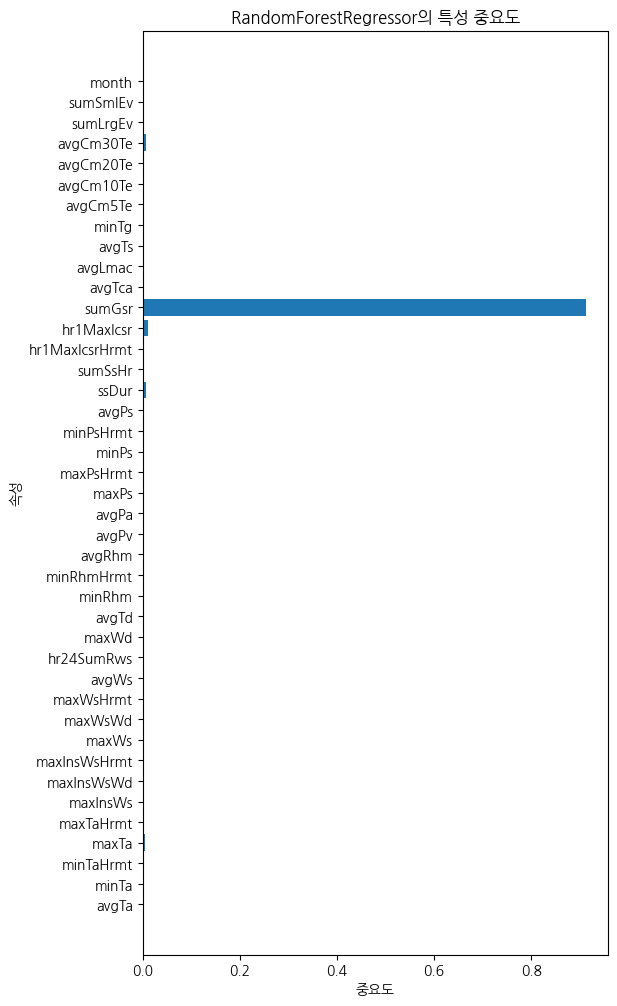

In [49]:
f_importances(model_rfr, X_train.columns, 'RandomForestRegressor의 특성 중요도')

##### XGBRegressor

In [59]:
model_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    n_jobs=-1,
    max_depth=3,
    learning_rate=0.11,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=SEED
).fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)
_ = regression_evaluation(y_test, pred_xgb)

R2_SCORE: 0.896457, MAPE2: 9.738041, MSE: 780391659520.162476, RMSE: 883397.792345, MAPE: 0.126531, MAE: 508779.792259


* 영향도

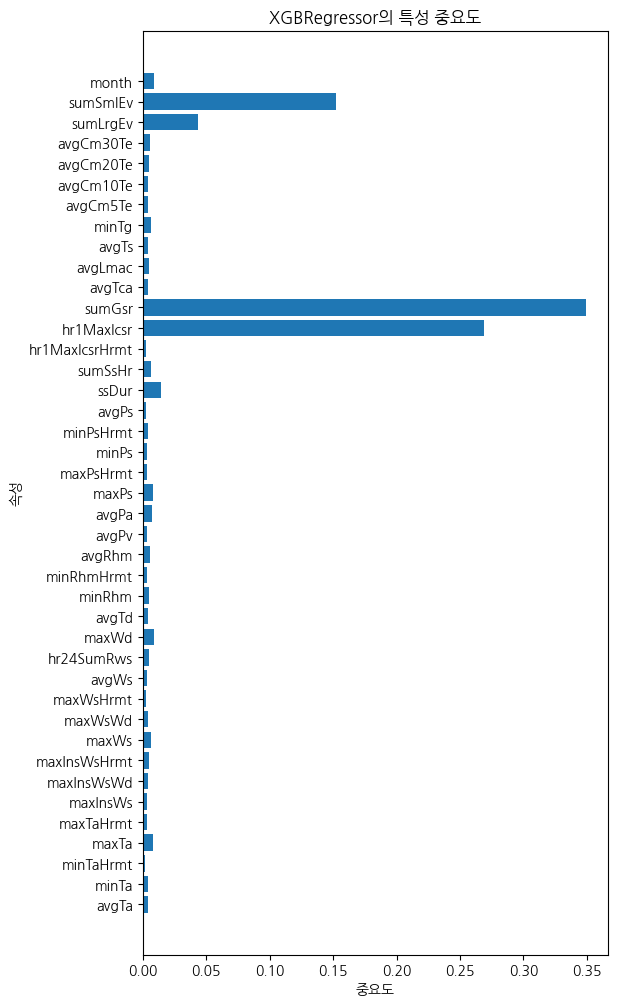

In [ ]:
f_importances(model_xgb, X_train.columns, 'XGBRegressor의 특성 중요도')

#### ML 시계열 모델링

##### 시계열 데이터 추출

In [ ]:
X_train = df_cutoff.drop(target_col, axis=1)
X_test = df_test.drop(target_col, axis=1)

X_train, X_test = X_train.set_index('tm'), X_test.set_index('tm')

##### XGBRegressor

In [ ]:
model_xgb_t = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    n_jobs=-1,
    max_depth=3,
    learning_rate=0.11,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED
).fit(X_train, y_train)

pred_xgb_t = model_xgb_t.predict(X_test)
_ = regression_evaluation(y_test, pred_xgb_t)

R2_SCORE: 0.893235, MAPE2: 9.941542, MSE: 804673592244.020996, RMSE: 897036.003873, MAPE: 0.126115, MAE: 516500.561790


* 결과 확인(이미지)

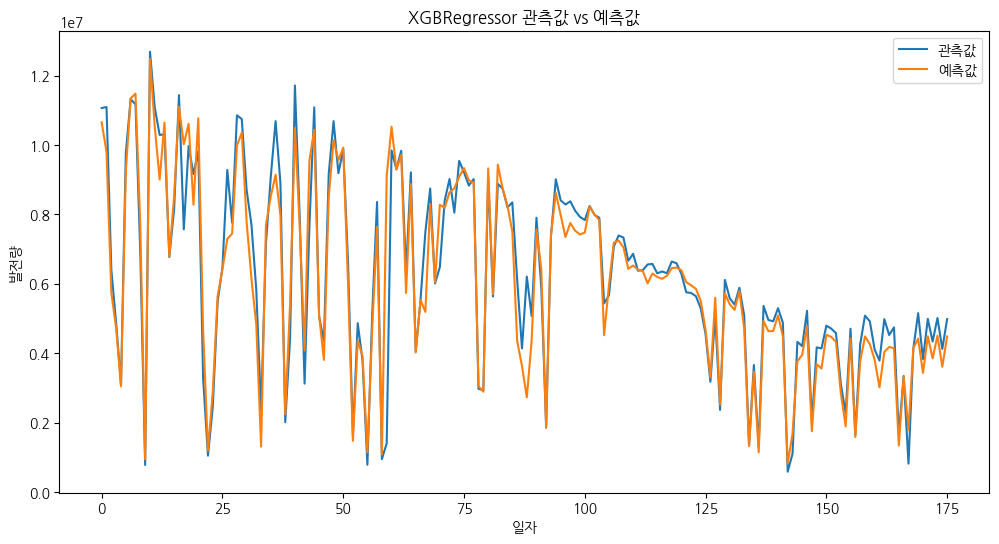

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(y_test, label='관측값')
plt.plot(pred_xgb_t, label='예측값')
plt.xlabel('일자')
plt.ylabel('발전량')
plt.legend()
plt.title('XGBRegressor 관측값 vs 예측값')
plt.show()

#### DL 시계열 모델링

In [ ]:
# 혹시 몰라 백업
X_test_b, X_train_b = X_test.copy(), X_train.copy()

##### CNN

In [ ]:
WINDOW_SIZE = 10        # 과거 10일치 데이터로 분석

In [ ]:
# 윈도우사이즈-1 크기의 데이터를 X_test에 추가(X_train의 마지막 데이터)
X_test = pd.concat([X_train.tail(WINDOW_SIZE-1), X_test])

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def make_window(data):
    _window = []
    for i in range(data.shape[0]-WINDOW_SIZE+1):
        _element = []
        for j in range(WINDOW_SIZE):
            _element.append(data[i+j])
        _window.append(_element)
    return np.array(_window)

In [ ]:
    X_train_win = make_window(X_train_scaled)
    X_test_win = make_window(X_test_scaled)

In [ ]:
# y_train값은 윈도우사이즈-1 만큼 줄여준다.
y_train = y_train[WINDOW_SIZE-1:]

# y_test는 검증값이기 때문에 줄이지 않고, 
# X_test의 앞에 윈도우사이즈-1만큼 추가했기 때문에 크기가 동일함.

In [ ]:
X_train_win = X_train_win.reshape((*(X_train_win.shape), 1))
X_test_win = X_test_win.reshape((*(X_test_win.shape), 1))

In [ ]:
model_cnn = tf.keras.Sequential([
    # 여기도 차원이 너무 적어 보통 (3,3)을 하는데 (1,1)로 사용
    Conv2D(32, 1, activation='relu', input_shape=(X_train_win.shape[1:])),
    # MaxPooling2D((2,2)),    # 입력데이터의 차원이 너무적어(13*1*1) 이 부분은 전부 생략함
    Conv2D(64, 1, activation='relu'),
    # MaxPooling2D((2,2)),
    Conv2D(128, 1, activation='relu'),
    # MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model_cnn.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', 'mape']
)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 41, 32)        64        
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 41, 64)        2112      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 41, 128)       8320      
                                                                 
 flatten (Flatten)           (None, 52480)             0         
                                                                 
 dense (Dense)               (None, 64)                3358784   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

2023-08-27 15:18:36.593847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 15:18:36.597885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 15:18:36.598060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# 모델 훈련
model_cnn.fit(
    X_train_win, y_train, 
    epochs=100, batch_size=32, verbose=0, 
    validation_split=0.2
)

2023-08-27 15:18:38.306289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-08-27 15:18:38.738786: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-27 15:18:38.835667: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1dd6c9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-27 15:18:38.835688: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-27 15:18:38.839885: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-27 15:18:38.892916: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-27 15:18:38.936244: I ./tensorflow/compiler/jit/device_compiler

In [ ]:
pred_cnn = model_cnn.predict(X_test_win)

6/6 [==============================] - 0s 17ms/step


In [ ]:
regression_evaluation(y_test, pred_cnn.reshape(-1))

R2_SCORE: 0.868006, MAPE2: 13.375923, MSE: 994820978883.866699, RMSE: 997407.127949, MAPE: 0.163629, MAE: 688278.162287


(994820978883.8667,
 997407.1279491974,
 688278.1622869318,
 0.16362856945010099,
 13.375923313635429)

: 